# Preparing SPED data for templatematching - an example

## Contents
 1. [Loading raw data](#1.-Load-raw-data)
 2. [Reshaping raw data](#2.-Reshape-and-prepare-the-raw-data)
 3. [Plotting and metadata](#3.-Plotting-and-metadata)
 4. [Save converted data](#4.-Saving-converted-data)
 5. [Load converted data](#5.-Load-the-converted-data)
 6. [VBF and cropping](#6.-Create-VBF-and-crop-the-data)
 7. [Center data](#7.-Center-data) 
 8. [Calibrate diffraction space](#8.-Calibrate-diffraction-space)
 9. [Save processed data](#9.-Save-processed-data)
 10. [Load processed data](#10.-Load-processed-data)
 11. [Basic VDF analysis](#11.-Basic-VDF-analysis)

## Introduction
This notebook shows how to prepare Scanning Precession Electron Diffraction (SPED) data for template matching through an example dataset of FIB lamella of Silver. This dataset is available by request from [emil.christiansen@ntnu.no](emil.christiansen@ntnu.no) through the following link: [https://studntnu-my.sharepoint.com/:f:/r/personal/emilc_ntnu_no/Documents/NORTEM/Data/DemoData/SPED_Ag?csf=1&web=1&e=ej997R](https://studntnu-my.sharepoint.com/:f:/r/personal/emilc_ntnu_no/Documents/NORTEM/Data/DemoData/SPED_Ag?csf=1&web=1&e=ej997R). Download this data to your local computer (e.g. same location as this notebook) and copy the path into the `datapath` variable below.

In [1]:
%matplotlib qt
import hyperspy.api as hs #General hyperspy package
import pyxem as pxm #Electron diffraction tools based on hyperspy
import numpy as np #General numerical and matrix support
import matplotlib.pyplot as plt #Plotting tools
import matplotlib.colors as mcolors #Some plotting color tools

#Import path handling tool
from pathlib import Path
import json

def read_hdr(filename):
    """
    Return the content of a .hdr file as a dictionary
    """
    filename=Path(filename)
    if not filename.suffix == '.hdr':
        raise ValueError(f'Cannot read hdr file: File "{str(filename)}" is not a .hdr file')
    hdr = {}
    with filename.open('r') as f:
        for line in f.readlines():
            content = line.split(':', maxsplit=1)
            if len(content)>1:
                hdr[content[0].strip()] = content[1].strip()
    return hdr

# 1. Load raw data
The data consists of three parts:
  - The actual raw diffraction data in "SPED.mib"
  - A "SPED.hdr" file with detector state information
  - A "parameters.json" file with various manually recorded metadata from the microscope

Let us load all of these three files...

In [2]:
#datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\excite cambridge\D5 muscovite\20230711_124805\sped_256x256_30x30_15x15nn_MP_6_CL_91mm_1deg_100hz_10ms.mib")C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle9\0X0Y\20231108_131447
#datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle9\0X0Y\20231108_131447\SPED_256x256x12_5x5_1p745x1p745nm_NBD_alpha5_spot0p5nm_CL10cm_1deg_100Hz.mib")
#datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle9\0X0Y\20231108_131447\SPED_256x256x12_5x5_1p745x1p745nm_NBD_alpha5_spot0p5nm_CL10cm_1deg_100Hz.mib")

#datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle5\0X0Y\20231108_152425\SED_128x128x12_30x30_10p47x10p47nm_NBD_alpha5_spot0p5nm_CL10cm_0deg.mib")
#datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle9\0X0Y\20231108_132728\SED_256x256x12_5x5_1p745x1p745nm_NBD_alpha5_spot0p5nm_CL10cm_0deg.mib")

#datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle9\0X0Y\20231108_134154/SPED_11x11x24_120x120_42x42nmnm_NBD_alpha5_spot0p5nm_CL10cm_1deg_100Hz_descanOff.mib")
datapath = Path(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\excite cambridge\D5 muscovite\20230711_130113\sed_256x256_30x30_15x15nn_MP_6_CL_91mm_0deg_100hz_10ms.mib")



In [3]:
mib_data = pxm.load_mib(str(datapath))
hdr = read_hdr(datapath.with_suffix('.hdr'))
with open(datapath.parent/'metadata.json', 'r') as j:
    parameters = json.loads(j.read())

This mib file appears to be TEM data. The stack is returned with no reshaping.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hfyhn\\Documents\\Skole\\Fordypningsoppgave\\Data\\excite cambridge\\D5 muscovite\\20230711_130113\\metadata.json'

In the cell above, `pxm.load_mib()` is used to read the data, while a custom function defined earlier in this notebook is used to read the .hdr file. To read the .json file with our parameters, we use the `json.load()` together with the `Path` objects `.open()` function.

Now, let us take a look at each of these different objects:

In [18]:
print(mib_data)

<LazyElectronDiffraction2D, title: , dimensions: (65536|256, 256)>


The .mib data is loaded as a `LazyElectronDiffraction2D` dataset, without a title, and with dimensions `(256000|256, 256)`. The "lazy" part is a clever trick that enables us to work with big datasets without loading everything into memory at the same time. The dimensions in hyperspy are defined as $(X, Y|k_x, k_y)$, where $X$ and $Y$ are the real-space (also called "navigation axes", and $k_x$ and $k_y$ are the reciprocal axes (also called the "signal axes"). The distinction will become clearer as we go. For now, it is enough to recognize that the data is loaded as a 1-D array (of length $256000$) of diffraction patterns (each with size $256\times256$).

In [19]:
print(hdr)

{'Time and Date Stamp (day, mnth, yr, hr, min, s)': '08/11/2023 13:14:47', 'Chip ID': 'W559_G11, - , - , -', 'Chip Type (Medipix 3.0, Medipix 3.1, Medipix 3RX)': 'Medipix 3RX', 'Assembly Size (NX1, 2X2)': '1x1', 'Chip Mode  (SPM, CSM, CM, CSCM)': 'SPM', 'Counter Depth (number)': '12', 'Gain': 'SLGM', 'Active Counters': 'Counter 0', 'Thresholds (keV)': '4.000000E+1,5.110000E+2,0.000000E+0,0.000000E+0,0.000000E+0,0.000000E+0,0.000000E+0,0.000000E+0', 'DACs': '068,511,000,000,000,000,000,000,100,255,100,125,100,100,080,100,090,030,128,004,255,126,128,174,172,511,511; ; ;', 'bpc File': 'c:\\MERLIN_Quad_Config\\W559_G11\\W559_G11_SPM.bpc,,,', 'DAC File': 'c:\\MERLIN_Quad_Config\\W559_G11\\W559_G11_SPM.dacs,,,', 'Gap Fill Mode': 'None', 'Flat Field File': 'None', 'Dead Time File': 'Dummy (C:\\<NUL>\\)', 'Acquisition Type (Normal, Th_scan, Config)': 'Normal', 'Frames in Acquisition (Number)': '65536', 'Frames per Trigger (Number)': '1', 'Trigger Start (Positive, Negative, Internal)': 'Rising 

The .hdr file on the other hand, is read as a dictionary. In fact, this file is a simple text file that you can open in any text editor software. Our custom function loaded every line of this file into a dictionary so that the information is a little bit more accessible to us if we need it.

In [17]:
print(parameters)

{'B240': {'NBD_alpha': '5', 'spot': '0.5 nm', 'diff': '8 cm', 'condenser_aperture': 'smallest', 'precession': '0.7 deg', 'resolution': '1024x256 points', 'stepsize': '1.852 nm (=4)', 'scan_rotation': '0', 'Mirror_scan_x_off': 'true', 'Camera': {'on': '10 ms', 'off': '0.75 ms'}, 'flyback': '50 ms', 'pixel_trigger': 'enabled', 'continuous_mode': 'off', 'Merlin_scan_points': '1024x256', 'thresholds': {'high': '40 kV', 'low': '511 kV'}, 'frame': '10 ms', 'gap_time': '0.617 ms', 'counting_mode': '2x12 bit'}}


The `parameters.json` file is also loaded as a dictionary. This is very convenient for us as much of this information will be useful to us very soon. You will come across many different ways of recording acquisition parameters and other important metadata, and you will likely find your own way of doing it. However, the .json format is a very convenient way of storing it as you can create these files yourself in any text editor and it will be very easy to read them into python later on. The best advice is to find a way that works for you, and a combination of digital files and paper-notes will most likely be the best option.

# 2. Reshape and prepare the raw data
As we saw above, the .mib data was loaded as a 1D array of diffraction patterns. From the `parameters` dictionary loaded from the ".json" file we see that the data was acquired as a scan with $X=800$ and $Y=320$ pixels in the first and second directions, respectively. We can use these to reshape the data into a more meaningful representation. However, doing this requires retrieving the `data` object of the `mib_data`.

In [4]:
data = mib_data.data
print(data)

dask.array<reshape, shape=(65536, 256, 256), dtype=>u2, chunksize=(1021, 256, 256), chunktype=numpy.ndarray>


We see that the data is a `dask.array` object. This is an object that behaves as a `numpy` array, except that it supports the lazy functionality entioned earlier - it enables us to work with the data without loading everything into memory in one go! Instead, it loads "chunks" of this data into memory to work with when requested. The size of these chunks should not be too small (as that would require a lot of read/write operations when using the data) or too large (as that would require more memory). For diffraction data, for instance, we might only need certain parts of the pattern (such as pixels containing reflections), and it is convenient to work with a compomise - a chunksize of 32 is usually ok for many cases. Now, let us reshape the data and change the chunks:

In [5]:
scan_shape = (256,256)#(parameters['Y'], parameters['X']) #Note that hyperspy flips the axes, so Y is the first, and X is the second when reshaping the data
chunksize = 32

data = mib_data.data
data = data.reshape(scan_shape + mib_data.axes_manager.signal_shape)
data = data.rechunk((chunksize,)*4)
print(data)

dask.array<rechunk-merge, shape=(256, 256, 256, 256), dtype=>u2, chunksize=(32, 32, 32, 32), chunktype=numpy.ndarray>


Ignore the warnings - they are not crucial at this point. We see that our data is now reshaped into $(y, x, 256, 256)$ shape. We can now use this array to create a new `LazyElectronDiffraction2D` signal:

In [6]:
signal = pxm.signals.LazyElectronDiffraction2D(data)
print(signal)

<LazyElectronDiffraction2D, title: , dimensions: (256, 256|256, 256)>


# 3. Plotting and metadata

Now the time has come to start taking a look at our data, let's start by plotting it. You will notice that it takes some time to plot the data (at least the first time). This is because `hyperspy` needs to prepare a `navigator` for you to use to navigate the data. This `navigator` is effectively a map of your scan, and the default representation is that each "pixel" in this map is the sum of all the intensities in the associated diffraction pattern.

In the figures created by the next cell, you can press the `+` key on your keyboard to increase the size of a handle that you can click and drag around the `navigator` map - you should see the `signal` plot updating showing you the data associated to the central pixel in the handle.

In [7]:
signal.plot(norm = "symlog", cmap = "Greens_r")

[########################################] | 100% Completed | 24.10 s


C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()


You will see that the scales of the axes in the plots are all `<undefined>`. This is beacause we haven't set any metadata yet! Doing so requires us to either do some calibration ourselves, or have some reference data that we can use. Let us first set the data we can based on the content of our `parameters` dictionary we loaded from the ".json" file earlier.

Metadata can be stored in many ways for a signal. The two most important ways are in the `signal.axes_manager` object and the `signal.metadata` object. Calibrations and scales for the data are set in the `signal.axes_manager` object, while all kinds of metadata can be set in the `signal.metadata` object.

In [8]:
print(f'The signal metadata:\n{signal.metadata}')
print(f'The signal axes:\n{signal.axes_manager}')

The signal metadata:
├── General
│   └── title = 
└── Signal
    └── signal_type = electron_diffraction

The signal axes:
<Axes manager, axes: (11, 11|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
     <undefined> |     11 |      0 |       0 |       1 | <undefined> 
     <undefined> |     11 |      0 |       0 |       1 | <undefined> 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    256 |      0 |       0 |       1 | <undefined> 
     <undefined> |    256 |      0 |       0 |       1 | <undefined> 


We see that there is very little useful information here yet. Before we do something about that, let us first take a look at another useful `metadata` object: the `signals.original_metadata` object, which can be very useful to store e.g. our head file contents and the contents of `parameters.json`. The difference between `signal.metadata` and `signal.original_metadata` is that the former will be used and changed by `hyperspy` as you run various commands, while the latter will stay unchanged. The `original_metadata` is therefore a very convenient place for us to store our .hdr the `parameters` dictionaries to the `original_metadata`:

In [8]:
signal.original_metadata.add_dictionary({'HDR': hdr, 'Parameters': parameters})
print(signal.original_metadata)

NameError: name 'parameters' is not defined

Here we see that the `original_metadata` follows a tree-like structure. If you have nested dictionaries of metadata you want to add, that is no problem at all! The `metadata` object will have the same basic tree-structure.

Now, finally, let us set some useful metadata in the `signal.metadata` object. You can of course define your own metadata fields, but it is most convenient to use `hyperspy` functionality to set most of them to ensure a systematic way to store the data (by using e.g. `signal.set_experimental_parameters`):

In [10]:
signal.metadata.General.title='Muscovite' #Set the title of the data  - this will appear over all plots

#Set the most important experimental parameters
signal.set_experimental_parameters(beam_energy=parameters['Beam energy'],
                                   camera_length=parameters['Camleralength'],
                                   scan_rotation=parameters['Rotation'],
                                   rocking_angle=parameters['Rocking angle'],
                                   rocking_frequency=parameters['Rocking frequency'],
                                   exposure_time=parameters['Exposure time']
                                   )

In [11]:
print(signal.metadata)

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 10
│       │       └── exposure_time = 100
│       ├── beam_energy = 200
│       ├── rocking_angle = 1.0
│       ├── rocking_frequency = 100
│       └── scan_rotation = 0
├── General
│   └── title = Muscovite
└── Signal
    └── signal_type = electron_diffraction



Now we see that the `metadata` object contains alot more useful information!

Next, let us set the scan step size. This is already recorded in the `parameters` dictionary, so let us use one of those values (called `dx` or `dy` in this case).

In [12]:
signal.set_scan_calibration(parameters['dx'])
print(signal.axes_manager)

<Axes manager, axes: (11, 11|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     11 |      0 |       0 |     1.7 |     nm 
               y |     11 |      0 |       0 |     1.7 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    256 |      0 |       0 |       1 | <undefined> 
     <undefined> |    256 |      0 |       0 |       1 | <undefined> 


In [13]:
def wavelength(V, 
            m0=9.1093837015*1e-31, 
            e=1.60217662*1e-19, 
            h=6.62607004*1e-34 , 
            c=299792458):
    """
    Return the wavelength of an accelerated electron in [m]
    
    Arguments
    ---------
    V : float, Acceleration voltage of electrons [kV]
    m0 : float, Rest mass of electron [kg]
    e : float, Elementary charge of electron [C]
    h : float, Planck' constant [m^2 kg/s]
    c : float, Speed of light in vacuum [m/s]
    """
    V = V*1E3
    return h / np.sqrt( 2 * m0 * e * V * ( 1.0 + ( e*V / ( 2*m0*c**2 ) ) ) )

def get_d_spacing(a = 1, b = 1, c = 1, h = 0, k = 0, l = 0, beta = np.pi/2, crystal = "monoclinic"):
    if crystal == "cubic":
        return 1/(h**2 / a**2 + k**2/b**2 + l**2/c**2)**0.5
    
    if crystal == "monoclinic":
        return np.sin(beta)/(h**2/a**2 + k**2 * np.sin(beta)**2/b**2 + l**2 / c**2 - 2*h*l*np.cos(beta)/a*c)**0.5

In [15]:
l = wavelength(200)
p = 55E-6
c = 10E-2
#signal.set_scan_calibration(p/(l*c) * 1E-10)#parameters['dx'])
signal.axes_manager[-1].scale = p/(l*c) * 1E-10
signal.axes_manager[-2].scale = p/(l*c) * 1E-10

signal.axes_manager[-1].units = "$Å^{-1}$"
signal.axes_manager[-2].units = "$Å^{-1}$"

signal.axes_manager[-1].Name = "kx"
signal.axes_manager[-2].Name = "ky"
print(signal.axes_manager)

<Axes manager, axes: (11, 11|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     11 |      0 |       0 |     1.7 |     nm 
               y |     11 |      0 |       0 |     1.7 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
     <undefined> |    256 |      0 |       0 |   0.022 | $Å^{-1}$ 
     <undefined> |    256 |      0 |       0 |   0.022 | $Å^{-1}$ 


# 4. Saving converted data

In [16]:
#signal.save(r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\Excite_Illite\SED_256x256_5x5_2p3x2p3nm_NBD5_1nm_12cm", overwrite=True, chunks=(chunksize,) * 4)
signal.save(str(datapath.parent) + r"\\" + (datapath.stem) + ".hspy")

#signal = hs.load(str(datapath), lazy=True) #Use the lazy keyword to work with big datasets without loading everything into memory at once

# 5. Load the converted data

In [11]:
#location = r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\excite cambridge\D5\20230711_124805"
#location = r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\excite cambridge\A5 illite\20230710_112932"
#location = r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\excite cambridge\D5 muscovite\20230711_124805"
location = r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\excite cambridge\A5 illite\20230710_134854"

#location = r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle9\0X0Y\20231108_131447\hyperSpy\SPED_256x256x12_5x5_1p745x1p745nm_NBD_alpha5_spot0p5nm_CL10cm_1deg_100Hz_centered.hspy"
#location = r"C:\Users\hfyhn\Documents\Skole\Fordypningsoppgave\Data\2023_11_08_Muscovite\Particle5\0X0Y\20231108_152425\hyperSpy/SED_128x128x12_30x30_10p47x10p47nm_NBD_alpha5_spot0p5nm_CL10cm_0deg.hspy"


path = r"\hyperSpy"
#path = r"\HyperSpy"
#datapath = Path(location)
#datapath = Path(location + path + r"\crystal_3" + ".hspy")

#datapath = Path(location + path + r"\sped_256x256_30x30_15x15nn_MP_6_CL_91mm_1deg_100hz_10ms_centered" + ".hspy")
datapath = Path(location + path + r"\crystal_1_centered" + ".hspy")

signal = hs.load(str(datapath), lazy=False)

### Inspect the data
#### Print some info

In [10]:
print(f'The signal:\n{signal}\n') #Print information about the signal
print(f'Axes information:\n{signal.axes_manager}\n') #Print information about the axes
#print(f'Data:\n{signal.data}\n')

The signal:
<ElectronDiffraction2D, title: Muscovite, dimensions: (256, 256|256, 256)>

Axes information:
<Axes manager, axes: (256, 256|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    256 |      0 |       0 |     1.9 |     nm 
               y |    256 |      0 |       0 |     1.9 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |      0 |    -1.4 |   0.011 | $Å^{-1}$ 
              ky |    256 |      0 |    -1.4 |   0.011 | $Å^{-1}$ 



We see that the signal is a `LazyElectronDiffraction2D` signal without a title, and with 320 x 800 probe positions with a diffraction pattern of 256 x 256 pixels in each position.

We also see that the scan step sizes are calibrated, but the diffraction scales are not. This information should _always_ be verified by additional data (calibration samples or reference images)

#### Plot the data to see what we have
Run the next cell and move around in navigation space to see the different diffraction patterns we have in the sample

In [9]:
def update_axes_manager(s, step_size, dx, dy,cl):
    names = ['x', 'y', 'kx', 'ky']
    scan_units = "nm"
    
    scales = [step_size[0], step_size[1], dx, dy]
    offsets = [0, 0, -dx*s.axes_manager[2].size/2, -dy*s.axes_manager[2].size/2]
    units = [scan_units, scan_units, '$Å^{-1}$', '$Å^{-1}$']
    for ax_no, (name, scale, offset, unit) in enumerate(zip(names, scales, offsets, units)):
        s.axes_manager[ax_no].name = name
        s.axes_manager[ax_no].scale = scale

        s.axes_manager[ax_no].offset = offset
        s.axes_manager[ax_no].units = unit    
        
    return s

In [12]:
signal = update_axes_manager(signal, [19.2086316]*2, 0.010212846154005488, 0.010212846154005488,128.9688844279534)

signal.plot(norm='symlog') #Plot the data with a "symmetrical log" intensity scale (this avoids log(0) which is undefined

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()


Run the next cell to create interactive virtual images of the data

In [7]:
#roi = hs.roi.CircleROI(0.0, 0.0, 0.1) #For calibrated data sets
# For uncalibrated data sets:
nx, ny = 256,256#signal.axes_manager.signal_shape#Get the signal shape
nx *= signal.axes_manager[2].scale 
ny *= signal.axes_manager[3].scale 
print(nx)
roi = hs.roi.CircleROI(0.00, 0.00, 0.07) #For calibrated data sets, position the ROI at the middle of the diffraction pattern and with a radius of 10 pixels
signal.plot_integrated_intensity(roi)

2.614488615425405


In [22]:
print(roi)

CircleROI(cx=0.0102128, cy=0.0612771, r=0.137873, r_inner=0)


# 6. Create VBF and crop the data
It is often useful to use a virtual bright field (VBF) image when cropping the data. You can use this to represent the data and add a ROI widget that you can freely move around before using it to crop the data.

First, create a VBF

In [19]:
vbf = signal.get_integrated_intensity(hs.roi.CircleROI(cx=2.40993E-05, cy=0, r=0.000325341, r_inner=0))
vbf.compute()

[########################################] | 100% Completed | 88.62 s


Next, plot the VBF and add a ROI widget to the data. Move the ROI around the VBF and reshape it to cover the most interesting parts of the data

In [20]:
vbf.plot()
#left, right, top, bottom = vbf.axes_manager.signal_extent #Set the roi to cover the whole scan area
left, right, top, bottom = 1385.3, 8077.5, 234.278, 1028.79 #Select a pre-defined region
roi = hs.roi.RectangularROI(left=left, right=right, top=top, bottom=bottom)
roi.add_widget(vbf)

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()


Run the next cell to crop the data. Note that this overwrites the `signal` variable, so if you regret your cropping, you will have to reload the original data!

In [21]:
signal = roi(signal) 

Plot the cropped data to verify that it looks good

In [22]:
signal.plot(norm='symlog')

[########################################] | 100% Completed | 8.89 ss


Save the cropped data

In [29]:
signal.save(datapath.with_name(f'{datapath.stem}_cropped.hspy'))

Load the newly created cropped dataset - useful if you are starting the notebook over at a later point

In [5]:
signal = hs.load(datapath.with_name(f'{datapath.stem}_cropped.hspy'), lazy=True)

Print the signal to verify its shape, data size, etc

In [23]:
signal

<LazyElectronDiffraction2D, title: , dimensions: (84, 81|256, 256)>

# 7. Center data 

In [44]:
def make_nav_mask(signal, width=None):
    mask = hs.signals.Signal2D(np.zeros(signal.axes_manager.navigation_shape, dtype=bool).T).T
    if width is not None:
        mask.inav[width:-width, width:-width] = True
    return mask

def correct_shifts_COM(signal, com_mask, nav_mask=None, plot_results=False, inplace=False):
    com = signal.center_of_mass(mask=com_mask)
    if plot_results:
        com.get_bivariate_histogram().plot()
        
    beam_shift = pxm.signals.BeamShift(com.T)
    beam_shift.make_linear_plane(mask=nav_mask)
    print(beam_shift)
    print(beam_shift.isig[0] - signal.axes_manager.signal_shape[0]/2.0)
    print(beam_shift.isig[1], signal.axes_manager.signal_shape[1]/2.0)

    x_shift, y_shift = [beam_shift.isig[ax] - signal.axes_manager.signal_shape[ax]/2.0 for ax in (0, 1)]
    
    print(f'Estimated beam shift X min/max = ({x_shift.min().data}, {x_shift.max().data})\nEstimated beam shift Y min/max = ({y_shift.min().data}, {y_shift.max().data})')
    
    dp_max_before = signal.max(axis=[0, 1])
    
    #A trick to make sure that the shifted signal contains the same metadata etc as the original signal. Might not be needed...
    if not inplace:
        shifted_signal = signal.deepcopy()
    else:
        shifted_signal = signal
    
    shifted_signal.shift_diffraction(x_shift, y_shift, inplace=True)
    
    dp_max_after = shifted_signal.max(axis=[0, 1])
        
    if plot_results:
        hs.plot.plot_images([dp_max_before, dp_max_after], overlay=True, colors=['w', 'r'], axes_decor='off', alphas=[1, 0.75])
    
    return shifted_signal, x_shift, y_shift
    

In [32]:
dp_max = signal.max(axis=[0, 1])

In [33]:
(roi.cx, roi.cy, roi.r)


(0.0, 0.0, 0.0029521694141985133)

In [43]:
dp_max.plot(norm='symlog')
x0, y0 = dp_max.axes_manager.signal_shape
x0, y0 = x0//2, y0//2
roi = hs.roi.CircleROI(x0, y0, 10)
roi.add_widget(dp_max)

In [45]:
shifted_signal, shift_x, shift_y = correct_shifts_COM(signal, (roi.cx, roi.cy, roi.r), plot_results=False)

[########################################] | 100% Completed | 10.88 ss
<BeamShift, title: , dimensions: (84, 81|2)>
<BaseSignal, title: , dimensions: (84, 81|)>
<BaseSignal, title: , dimensions: (84, 81|)> 128.0
Estimated beam shift X min/max = ([-0.69649174], [1.5939149])
Estimated beam shift Y min/max = ([-1.82969391], [0.11826048])


In [46]:
nx, ny = shifted_signal.axes_manager.signal_shape
nx, ny = nx/2.0, ny/2.0
shifted_signal_2, shift_x, shift_y = correct_shifts_COM(shifted_signal, (nx, ny, roi.r,), plot_results=True)

[########################################] | 100% Completed | 22.14 s
<BeamShift, title: , dimensions: (84, 81|2)>
<BaseSignal, title: , dimensions: (84, 81|)>
<BaseSignal, title: , dimensions: (84, 81|)> 128.0
Estimated beam shift X min/max = ([-0.24256196], [0.6087789])
Estimated beam shift Y min/max = ([-0.7234763], [0.0461724])


In [47]:
signal = shifted_signal_2

# 8. Calibrate diffraction space

Plot the data and move to a pattern you can index manually

In [48]:
signal.plot(norm='symlog')

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\ipykernel\eventloops.py:128: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  el.exec() if hasattr(el, 'exec') else el.exec_()


Plot the pattern and add a line that you use to create a line-profile across some known reflections

In [49]:
#dp = dp_max
dp = signal.get_current_signal()
dp.plot(norm='symlog')
line = hs.roi.Line2DROI()
profile = line.interactive(dp)
profile.plot(norm='log')
span = hs.roi.SpanROI()
span.add_widget(profile)

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\signal1d.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min, y_max)
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\signal1d.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min, y_max)
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\signal1d.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min, y_max)
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\signal1d.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min, y_max)
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\signal1d.py:233: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min, y_max)


Calculate the scale of the diffraction patterns. 

_NB_: This cell is __only valid for cubic crystals!!__

Set the diffraction scale if you are satisfied

In [26]:
signal.set_diffraction_calibration(scale)

# 9. Save processed data

In [27]:
signal.save(datapath.with_name(f'{datapath.stem}_cropped_centered.hspy'))

[########################################] | 100% Completed | 166.03 s
[########################################] | 100% Completed | 111.08 ms


# 10. Load processed data

In [ ]:
signal = hs.load(datapath.with_name(f'{datapath.stem}_cropped_centered.hspy'), lazy=True)

# 11. Basic VDF analysis
Store some positions of the roi and create VDF images of them. Also add the positions of the "aperture" positions as markers to the diffraction pattern.

In [53]:
#roi = hs.roi.CircleROI(0.0, 0.0, 0.1) #For calibrated data sets
# For uncalibrated data sets:
nx, ny = signal.axes_manager.signal_shape #Get the signal shape
roi = hs.roi.CircleROI(0, 0, 10) #For calibrated data sets, position the ROI at the middle of the diffraction pattern and with a radius of 10 pixels
signal.plot_integrated_intensity(roi)

In [57]:
positions = [] #Create an empty list of virtual aperture positions

Run the next cell to add an aperture position to the list created above. Run it several times to store more aperture positions. IMPORTANT: this is a fairly "stupid" way of doing this - if you run it several times without moving or chaning the virtual aperture, you will most likely get unwanted results

In [60]:
positions.append(tuple([roi.cx, roi.cy, roi.r]))

Print the stored positions. This can be useful if you start the notebook over, as you can use these numbers to manually place the different ROIs

In [61]:
_ = [print(f' Position {i+1}: {position}') for i, position in enumerate(positions)]

 Position 1: (-0.0004578875009403501, -0.0002891921058570633, 0.00013254638209214738)
 Position 2: (-0.0004096888166308394, -0.0007711789489521685, 0.00013254638209214738)


Create new ROIs based on the stored positions. It seems a bit "backwards", not simply storing the ROIs we moved around, but it is important to realise that each ROI is a dynamic object. If you store it, move it and then store it again, both variables will point to the same object and only the updated ROI will be stored, not the first one! It is therefore sometimes necessary to do it the "hard way" and extract the current positions as we did above, and the create new ROIs based on those

In [63]:
if False: #Toggle this if you want to use predefined or previously manually measured positions
    positions = [
        (0.4570201218767853, -0.17474298777641795, 0.10081326231312035),
        (-0.02688353658098741, -0.4839036584577727, 0.10081326231312035),
        (-0.3226024389718485, -0.3763695121338233, 0.10081326231312035),
        (0.24195182922888647, -0.4301365852957981, 0.10081326231312035)
    ]
rois = [hs.roi.CircleROI(position[0], position[1], position[2]) for position in positions] #create new sets of virtual apertures based on the stored positions

Now, let us create VDFs and put some markers in a representative diffraction pattern to show which parts of the diffraction pattern was integrated to create each image

In [64]:
vdfs = [] #Create empty list of VDFs
dp_mean = signal.mean(axis=[0, 1]) #Create as mean diffraction pattern to show the positions of the apertures
#dp_mean.compute() #Calculate the mean (remember: we have not read the data into memory yet, and we need to call `compute()` to do so)
dp_max = signal.max(axis=[0, 1])
#dp_max.compute()
for i, roi in enumerate(rois):
    x, y, r_integration = roi.cx, roi.cy, roi.r

    r = np.sqrt(roi.cx**2 + roi.cy**2)
    phi = np.sign(roi.cy)*np.arccos(roi.cx/r)*180/np.pi
    degree_symbol = '$^{\circ}$'
    vdf = signal.get_integrated_intensity(roi)
    vdf.metadata.General.title = f'VDF {i} (d={r:.2f} {signal.axes_manager[2].units}, {phi:.0f}{degree_symbol})'
    vdfs.append(vdf)

    dp_mean.add_marker(hs.plot.markers.ellipse(x=x, y=y, width=r_integration, height=r_integration, color='r'), permanent=True)
    dp_mean.add_marker(hs.plot.markers.text(x=x, y=y, text=f'{i}', color='r'), permanent=True)

    dp_max.add_marker(hs.plot.markers.ellipse(x=x, y=y, width=r_integration, height=r_integration, color='r'), permanent=True)
    dp_max.add_marker(hs.plot.markers.text(x=x, y=y, text=f'{i}', color='r'), permanent=True)
    
[vdf.compute() for vdf in vdfs]
dp_mean.compute()
dp_max.compute()

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(


[########################################] | 100% Completed | 40.42 s
[########################################] | 100% Completed | 37.63 s
[########################################] | 100% Completed | 35.76 s
[########################################] | 100% Completed | 35.15 s


In [65]:
[vdf.compute() for vdf in vdfs]
dp_mean.compute()
dp_max.compute()

AttributeError: 'Signal2D' object has no attribute 'compute'

Let us plot the VDFs

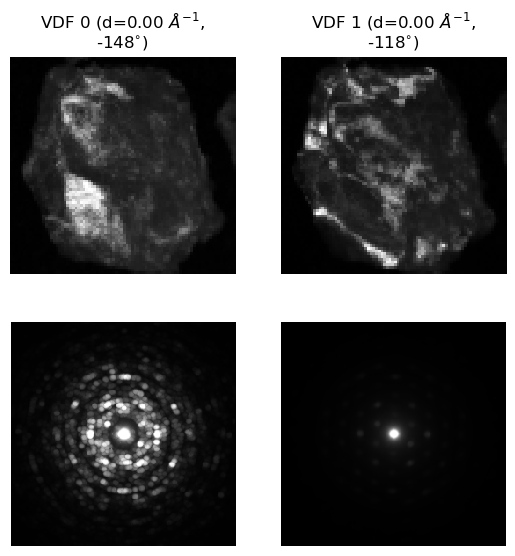

In [66]:
hs.plot.plot_images(vdfs+[dp_max, dp_mean], per_row=len(vdfs), axes_decor='off', colorbar=None)
fig = plt.gcf()
fig

We can also plot the images like this to make the marked diffraction patterns more visible

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(


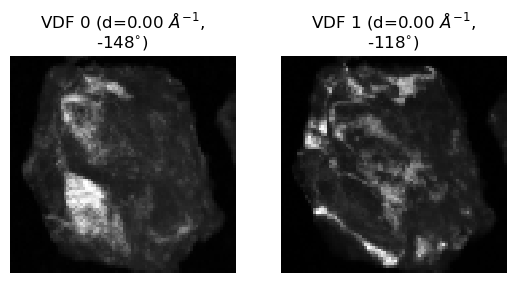

In [67]:
hs.plot.plot_images(vdfs, per_row = len(vdfs), axes_decor='off', colorbar=None)
fig = plt.gcf()
dp_mean.plot(norm='symlog')
dp_max.plot(norm='symlog')
fig

Let us also make individual plots of the images

In [68]:
colormap =plt.get_cmap('Greens_r')
for i, vdf in enumerate(vdfs):
    vdf.plot(cmap=colormap, colorbar=None, axes_off=True)
    plt.tight_layout()
    fig=plt.gcf()
    fig.savefig(datapath.with_name(f'{datapath.stem}_VDF{i}.png'))
    vdf.save(datapath.with_name(f'{datapath.stem}_VDF{i}.hspy'))

dp_max.plot(norm='symlog', cmap=colormap, colorbar=None, axes_off=True)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(datapath.with_name(f'{datapath.stem}_max_VDF_apertures.png'))

dp_mean.plot(norm='symlog', cmap=colormap, colorbar=None, axes_off=True)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(datapath.with_name(f'{datapath.stem}_mean_VDF_apertures.png'))

C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(
C:\Users\hfyhn\anaconda3\envs\pyxem\Lib\site-packages\hyperspy\drawing\_markers\ellipse.py:106: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  self.marker = self.ax.add_patch(patches.Ellipse(


Finally, let us see how we can overlay the different images and data to visualize them in a single image

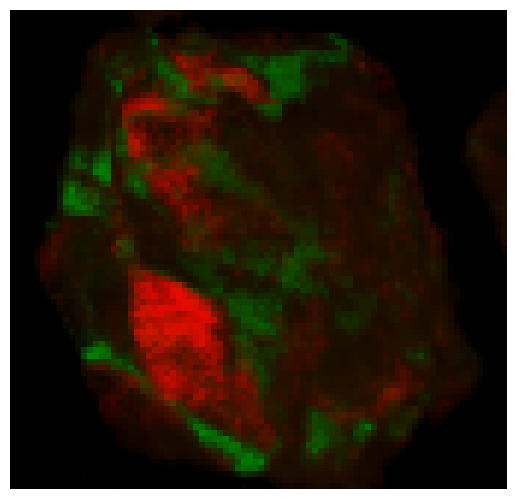

In [69]:
hs.plot.plot_images(vdfs, overlay=True, colors=['r', 'g', 'b', 'm'], axes_decor='off', label=None)
fig = plt.gcf()
fig

We can also create composite images of the diffraction patterns, showing which reflections are used for the different colors. Let us first do this based on the `dp_max` showing all the reflections in the data

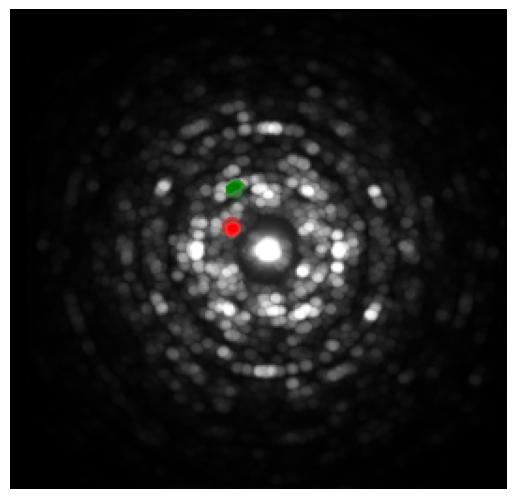

In [70]:
x, y = dp_max.axes_manager[0].axis, dp_max.axes_manager[1].axis
X, Y = np.meshgrid(y, x) #Create X and Y position matrices

kmax = 0.6 #Maximum scattering vector to show
dp_max_c = dp_max.isig[-kmax:kmax, -kmax:kmax].deepcopy() #Crop the dp_max down to a reasonable size - this will depend on the size of your plotted figure and the choice of reflections!
reflections = [dp_max_c*np.ones(dp_max_c.axes_manager.signal_shape)] #Create a list that will contain the diffraction patterns we wish to overlay at the end

#Loop through the ROIs and create circular masks based on them. Multiply this mask with the `dp_max_c` pattern to extract only that part from the pattern. Note that `roi(dp_max_c)` would not work!
for roi in rois:
    R = np.sqrt((X-roi.cx)**2 + (Y-roi.cy)**2)
    mask = R<=roi.r
    reflection = dp_max*mask
    reflections.append(reflection.isig[-kmax:kmax, -kmax:kmax])

#Plot the reflections as an overlay image in the same figure as we got before
axes = hs.plot.plot_images(reflections, overlay=True, colors=['w', 'r', 'g', 'b', 'm'], axes_decor='off', label=None, fig=fig)
ax = axes[0]
ax.set_anchor('NE') #Move the axis of the inset DP to the upper right corner of the map. Note that this will cover parts of the data!
#ax.set_position([0.12, 0, 1, 1])

fig.savefig(datapath.with_name(f'{datapath.stem}_VDF_overlay.png'))
fig

Alternatively, we can extract representative diffraction patterns from the different parts of the VDF to overlay those and show the color "maps" based on them instead. However, note that this is different from before where we showed which reflections were actually _used_ to create the VDFs. The following is used to _illustrate_ their patterns. 

In [71]:
#import some useful functions from scikit-image:
from skimage.filters import try_all_threshold, threshold_isodata, threshold_li, threshold_local, threshold_mean, threshold_minimum, threshold_triangle, threshold_otsu, threshold_yen

In [72]:
for vdf in vdfs:
    try_all_threshold(vdf.data)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


It looks like `threshold_li` works pretty well for most cases - so let us try that! If there are different algorithms that work better for different images you should modify the following code

In [73]:
masks = [vdf>threshold_func(vdf.data) for vdf, threshold_func in zip(vdfs, [threshold_li]*len(vdfs))] #Create masks
hs.plot.plot_images(masks, per_row=1, axes_decor='off', colorbar=None)

[<Axes: title={'center': 'VDF 0 (d=0.00 $Å^{-1}$,\n-148$^{\\circ}$)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'VDF 1 (d=0.00 $Å^{-1}$,\n-118$^{\\circ}$)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

Next, let us get rid of any overlap between the masks. For instance, the amorphous layer in the top part is common for all VDFs

In [74]:
stacked_masks = np.stack(masks)
common_mask = np.sum(stacked_masks, axis=0)
common_mask = common_mask<np.max(common_mask)
masks = [mask*common_mask for mask in masks]
hs.plot.plot_images(masks, per_row=1, axes_decor='off', colorbar=None)

[<Axes: title={'center': 'VDF 0 (d=0.00 $Å^{-1}$,\n-148$^{\\circ}$)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'VDF 1 (d=0.00 $Å^{-1}$,\n-118$^{\\circ}$)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

Now, let us apply these masks to our VDFs

In [75]:
transposed_signal = signal.T

In [76]:
transposed_signal

<LazyElectronDiffraction2D, title: , dimensions: (256, 256|84, 81)>

In [77]:
dps = [(transposed_signal*mask).sum(axis=[2, 3]).T/np.count_nonzero(mask) for mask in masks] #calculate the sum and divide by the number of True pixels in our masks. This gives a "mean" diffraction pattern of the included areas

In [78]:
dps

[<LazyElectronDiffraction2D, title: , dimensions: (|256, 256)>,
 <LazyElectronDiffraction2D, title: , dimensions: (|256, 256)>]

In [79]:
[dp.compute() for dp in dps]

[########################################] | 100% Completed | 32.05 s
[########################################] | 100% Completed | 29.72 s


[None, None]

Now, let us also remove the direct beam as it holds no useful information and will only reduce the contrast in the resulting image

In [80]:
masked_dps =[]
for dp in dps:
    x, y = dp.axes_manager[0].axis, dp.axes_manager[1].axis
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    masked_dps.append(dp*(R>0.1))

Finally, let us plot an overlayed image of the patterns

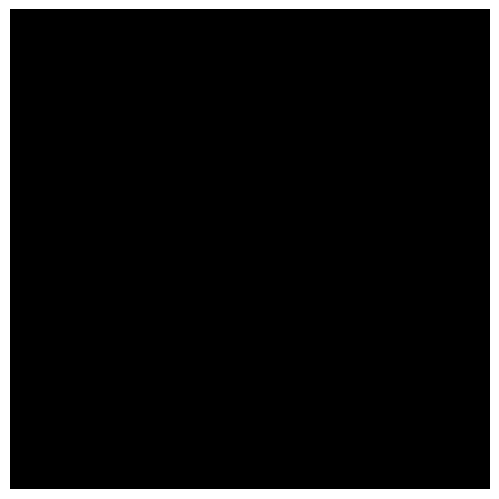

In [81]:
hs.plot.plot_images(masked_dps, overlay=True, axes_decor='off', label=None, colors=['r', 'g', 'b', 'm'], alphas=[1, 1, 1, 1])
fig = plt.gcf()
fig.savefig(datapath.with_name(f'{datapath.stem}_VDF_patterns.png'))
fig

The image above is not perfect. When inspecting the data, we saw that it is only the $(111)$ planes that are different in all of the twins, while the $(110)$ planes are common in different combinations for the different twins. Hence, the colors for the shortest $\vec{g}$ seen in the image above should not be trusted. It would be best to either remove them, or to change the image colors and transparencies to show that they should in fact be multi-colored. Nevertheless, the $(111)$ planes should have a color that matches their VDF counterparts

### Verifying scan orientation
We should also go one step further and see that the diffraction patterns are aligned correctly with our scan. 

    (1) Let us start by plotting the data and adding two lines, one in real space and the other in diffraction space. 
    (2) Navigate to two twins with a sharp boundary and align the real-space line with the boundary
    (3) Move the navigator handle across the boundary and see which reflections in the diffraction patterns remains the same. These reflections represents planes that are constant across the boundary
    (4) Align the diffraction space line with the planes that are constant across the boundary
    (5) Calculate the angular difference between the lines. The lines should have a 90 degrees angle between them

In [82]:
signal.plot(norm='symlog')
l1 = hs.roi.Line2DROI()
l1.add_widget(signal, axes=[0, 1])
l2 = hs.roi.Line2DROI()
l2.add_widget(signal, axes=[2, 3])

In [83]:
angles = [l.angle() for l in [l1, l2]]
misalignment = (max(angles) - min(angles)) - 90
if misalignment < 0:
    direction = 'ccw'
else:
    direction='cw'

print(f'Diffraction patterns are rotated {abs(misalignment):.2f} degrees {direction} compared to scan')

Diffraction patterns are rotated 88.95 degrees ccw compared to scan


As you can see, the diffraction patterns are rotated by about $64^{\circ}$ compared to the scan. This is very important for subsequent analysis and when representing the data! Indeed, if you remember at the very start of this notebook, the scan rotation was read from the `.json` file and added to the metadata. It's value was $296^{\circ}$. Since $64+296=360$, our numbers match up!

In the case of our VDFs and diffraction patterns made earlier, it is generally best toexport the images as usual (as we did above), but before putting them into any paper, report, thesis, or presentation, we should rotate the diffraction patterns in e.g. inkscape!